In [1]:
import numpy as np
import pandas as pd


In [2]:
df=pd.read_csv(r'/content/ab_test_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36126 entries, 0 to 36125
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   click            36126 non-null  int64  
 1   group            35787 non-null  object 
 2   session_time     36126 non-null  float64
 3   click_time       35760 non-null  object 
 4   device_type      36126 non-null  object 
 5   referral_source  35943 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.7+ MB


In [4]:
df.shape

(36126, 6)

In [6]:
df.head()

,click,group,session_time,click_time,device_type,referral_source
0,1,exp,0.040363,NaN,mobile,search
1,0,exp,1.639570,2024-01-14 22:15:00,mobile,email
2,0,exp,2.961715,2024-01-01 15:36:00,mobile,direct
3,1,exp,2.784540,2024-01-04 17:39:00,desktop,email
4,0,exp,2.495874,2024-01-07 17:31:00,mobile,social


In [10]:
df.describe()

,click,session_time
count,36126.000000,36126.000000
mean,0.494879,12.712176
std,0.499981,78.346651
min,0.000000,0.000100
25%,0.000000,1.454267
50%,0.000000,3.537967
75%,1.000000,7.121638
max,1.000000,807.785808


In [11]:
df.columns

Index(['click', 'group', 'session_time', 'click_time', 'device_type',
       'referral_source'],
      dtype='object')

In [15]:
df['group'].value_counts()


,count
group,
exp,35022
Exp,217
con,187
a,185
A,176


In [17]:
df['click'].value_counts()


,count
click,
0,18248
1,17878


In [18]:
df = df.drop_duplicates()


In [19]:
df.isnull().sum()

,0
click,0
group,339
session_time,0
click_time,366
device_type,0
referral_source,183


In [20]:
df = df.dropna(subset=['group', 'click', 'device_type'])


In [21]:
df['group'] = df['group'].str.lower().str.strip()
df['device_type'] = df['device_type'].str.lower().str.strip()
df['referral_source'] = df['referral_source'].str.lower().str.strip()


In [22]:
df['group'].value_counts()

,count
group,
exp,35239
a,361
con,187


In [23]:
group_mapping = {
    'a': 'control',
    'con': 'control',
    'exp': 'treatment'
}

df['group'] = df['group'].map(group_mapping)


In [24]:
df['group'].value_counts()


,count
group,
treatment,35239
control,548


In [25]:
ctr_by_group = (
    df.groupby('group')['click']
      .mean()
      .reset_index()
      .rename(columns={'click': 'ctr'})
)

ctr_by_group


,group,ctr
0,control,0.463504
1,treatment,0.494537


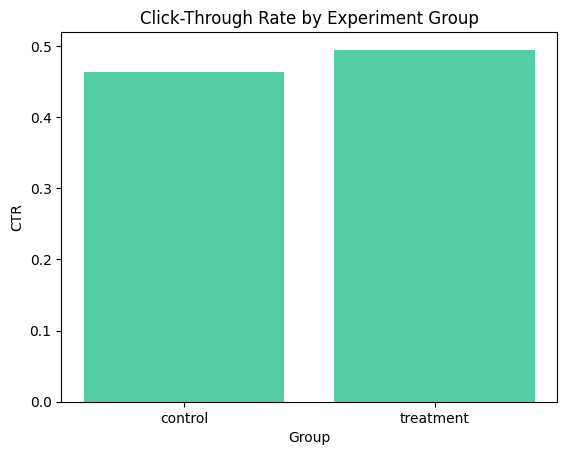

In [26]:
import matplotlib.pyplot as plt

plt.bar(ctr_by_group['group'], ctr_by_group['ctr'],color='#53cfa3')
plt.title("Click-Through Rate by Experiment Group")
plt.ylabel("CTR")
plt.xlabel("Group")
plt.show()


In [27]:
ctr_device = (
    df.groupby(['group', 'device_type'])['click']
      .mean()
      .reset_index()
)

ctr_device


,group,device_type,click
0,control,desktop,0.481481
1,control,mobile,0.455959
2,treatment,desktop,0.496625
3,treatment,mobile,0.493613


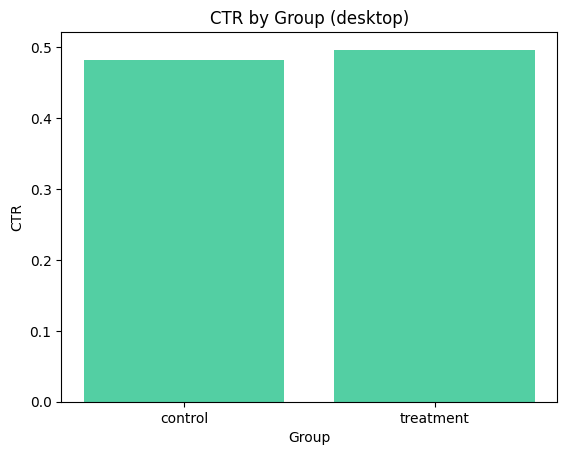

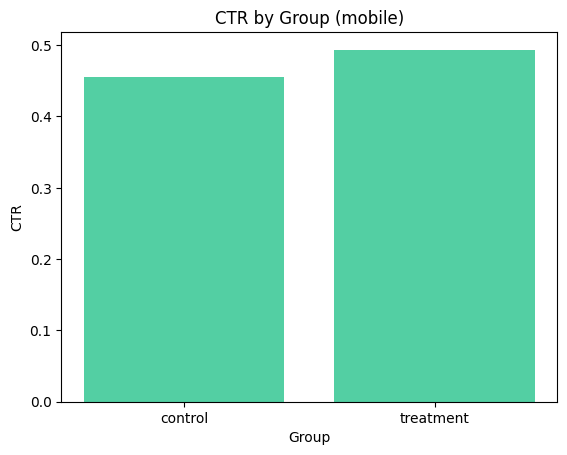

In [29]:
for device in ctr_device['device_type'].unique():
    subset = ctr_device[ctr_device['device_type'] == device]
    plt.bar(subset['group'], subset['click'],color='#53cfa3')
    plt.title(f"CTR by Group ({device})")
    plt.ylabel("CTR")
    plt.xlabel("Group")
    plt.show()


In [30]:
ctr_referral = (
    df.groupby(['group', 'referral_source'])['click']
      .mean()
      .reset_index()
)

ctr_referral.sort_values('click', ascending=False).head()


,group,referral_source,click
5,treatment,ad,1.000000
0,control,ads,0.519231
6,treatment,ads,0.503755
9,treatment,seach,0.502591
11,treatment,social,0.496322


In [32]:
df.groupby('group')['session_time'].mean()


,session_time
group,
control,15.233142
treatment,12.702958


In [34]:
control = df[df['group'] == 'control']
treatment = df[df['group'] == 'treatment']

n_control = len(control)
n_treatment = len(treatment)

clicks_control = control['click'].sum()
clicks_treatment = treatment['click'].sum()

n_control, clicks_control, n_treatment, clicks_treatment



(548, np.int64(254), 35239, np.int64(17427))

In [36]:
ctr_control = clicks_control / n_control
ctr_treatment = clicks_treatment / n_treatment

ctr_control, ctr_treatment


(np.float64(0.4635036496350365), np.float64(0.4945373024206135))

In [39]:
p_pool = (clicks_control + clicks_treatment) / (n_control + n_treatment)
p_pool


np.float64(0.4940620895856037)

In [41]:
import numpy as np

standard_error = np.sqrt(
    p_pool * (1 - p_pool) * (1/n_control + 1/n_treatment)
)

standard_error


np.float64(0.021522858792500446)

In [44]:
z_score = (ctr_treatment - ctr_control) / standard_error
z_score


np.float64(1.4418926911507948)

In [45]:
from scipy.stats import norm

p_value = 1 - norm.cdf(z_score)
p_value

np.float64(0.07466632419764085)

In [46]:
from scipy.stats import norm

z_critical = norm.ppf(0.95)

margin_of_error = z_critical * standard_error

ci_lower = (ctr_treatment - ctr_control) - margin_of_error
ci_upper = (ctr_treatment - ctr_control) + margin_of_error

ci_lower, ci_upper

(np.float64(-0.004368299561631726), np.float64(0.06643560513278576))